# <font color = "red">README <font>

To run the notebook, simply run all cells in the order listed.

This may take ~ 3 hours due to the runtimes of the $L_{2,1}$-NMF and tanh-NMF algorithms.

This work is inspired largely by this paper https://arxiv.org/abs/1906.00495. The aims are 
* To show how non-negative matrix factorisation is useful for certain types of data e.g., human faces
* To explain the general concept of NMF
* To implement NMF algorithms that are robust to noise

Algorithms that are robust to noise are valuable to real-world applications, where data usually carries low levels of noise. Here we deal with noise on the observations (pixels). In another folder in MachineLearningExamples, learning with noisy lables will be examined.

## Contents
1. Introduction to NMF
2. Loading Data
3. Running Basic NMF
4. Evaluating Basic NMF
5. Applying different noise algorithms to data
6. Implementing different NMF algorithms
7. Running evaluation of different algorithms
8. Results

# Imports

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn import datasets
import seaborn as sns
import cv2

# 1. Brief Introduction to NMF

The concept of NMF and initial algorithms were introduced in https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.640.8823&rep=rep1&type=pdf, please read that paper for more detail.

Non-negaitve matrix factorisation (NMF) is a type of dictionary learning procedure where a set of data $R$ is factorised to two matrices $P$ and $Q$ such that $R \approx PQ^T$, and all entries of both $P$ and $Q$ are strictly non-negative. If $R$ is an $n \times m$ matrix then $P$ is $n \times k$ and $Q$ is $m\times k$. 

Estimates for $P$ and $Q$ are achieved by minimising an objective function $l$ of the general form $l(R, P, Q)=R-PQ^T$. For example, using the $L_2$ norm loss function, the objective function 
$$
l(R, P, Q) = || R - PQ^T ||_F^2
$$
is yielded, where $||\cdot||_F$ is the Frobenius norm. In this work I examine how different objective functions may yield different levels of robustness to noise. 

We can think of the matrix $P$ as the dictionary that describes the common features of $R$ by $k$ basis vectors, and $Q$ as the set of coefficients that describe the differences, allowing each observation to be reconstructed. The choice of $k$ (the number of latent variables) can influence the accuracy of dictionary learning algorithms, however it is often desired that $k < m, n$ to achieve a compression via dictionary learning.

## 1.1 Motivation for non-negativity

By specifying $P$ and $Q$ to be non-negative, we learn a parts-based representation of $R$, meaning that $R$ can be reconstructed via only additive operations.

This is relevant to many applications where data is inherently non-negative, for example image data, medical signal data, and audio data. 

# 2. Loading the Data and Preprocessing

I am using the olivetti faces data set from AT&T Laboratories Cambridge through SciKit-Learn to allow for easier reproducibility. The documentation for the olivetti faces data is available here: https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset

The original size of these images is 64 x 64 which can create a high computational burden, so I am resizing to 32 x 32

In [2]:
def load_images(scaleDownFactor = 2):
    """
    Function that can resize Olivetti images upon loading.
    """
    faces = datasets.fetch_olivetti_faces()
    # Faces already returned np arrays
    ims = faces.images
    labels = faces.target
    
    # resize images using PIL
    images = []
    for im in ims:
        img = Image.fromarray(np.uint8(im*255))
        img = img.convert('L')
        img = img.resize(np.array(img.size) // scaleDownFactor)
        img = np.asarray(img)
        images.append(img)
        
    # Return images and labels
    return np.array(images), labels

In [3]:
images, labels = load_images()

We have 400 images of size 32 x 32 after downscaling by a factor of 2:

In [4]:
images.shape

(400, 32, 32)

In [5]:
labels.shape

(400,)

In [6]:
# Show a random selection of images
def plotImages(images, labels, imageShape = None, plotDims=3, width=10, height=12):
    if imageShape is not None:
        images = images.reshape(*imageShape)
    fig, axis = plt.subplots(plotDims, plotDims)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(plotDims**2):
        randInt = np.random.randint(images.shape[0]) 
        ax = axis[i%plotDims, i//plotDims]
        ax.imshow(images[randInt], cmap='gray')
        ax.set_title(labels[randInt])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

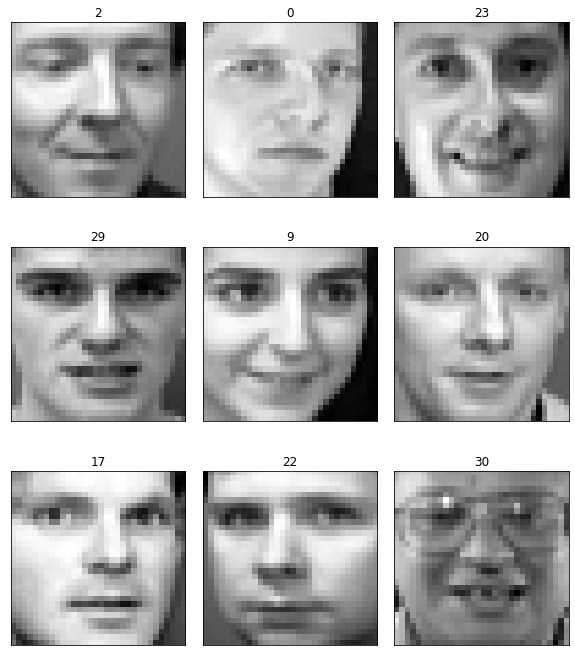

In [7]:
plotImages(images, labels)

Here the data matrix $R$ is the set of images, with $n=400$, however we need to convert from a $64 x 64$ image representation to representation compatible with a two dimensional data matrix $R$. We can reshape in numpy to achieve this:

In [8]:
def preprocess_images(images):
    """
    Reshapes from 400 x 64 x 64 to 400 x 4096
    Can add additional pre-processing if desired.
    """
    images = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    return images

In [9]:
imageShape = (images.shape[1], images.shape[2]) # having the original image shape will help later
images = preprocess_images(images)
images.shape

(400, 1024)

Now we have an $n \times m$ matrix to represent the image data. Sklearn returns the olivetti faces data scaled between 0-1 as floating point numbers, since it is already non-negative scaling to 0-255 when loading does not affect this, thus it is suitable for NMF. 

# 3. Basic NMF

Standard NMF is usually conducted with the $L_2$ norm as the loss function, with the optimisation procedure using multiplicative update rules as introduced in: https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf 

These rules are briefly reproduced here.

## 3.1 $L_2$ Norm NMF

Using the $L_2$ norm, we have the following loss function:

$$
l(R, P, Q) = || R - PQ^T ||_F^2
$$

where $R$ is the data matrix we wish to factorize, $Q$ are the dictionary terms, and $P$ are the coefficients.

Thus the requirement is to learn two matrices $P$ and $Q$. We can use gradient descent to learn these matrices such that the loss function is minimised, however to ensure this is a convex optimisation problem, $P$ must be held fixed whilst moving down the gradient of $Q$ and vice versa. This leads to the multiplicative update rules. 

The update rule for $P$ is:

$$
P' = P - \frac{\alpha}{2} \frac{dl}{dP}
$$

and for Q is:

$$
Q' = Q - \frac{\alpha}{2} \frac{dl}{dQ}
$$

Here $\alpha / 2$ is the learning rate. In the above paper, they show how to set $\alpha$ such that the resulting updates maintain the non-negativity constraints, which is reproduced below.

### 3.1.1 Update rule for Q

Lets first consider the update rule for $Q$. After taking the derivative, it becomes:
$$Q' = Q - \frac{\alpha}{2} \Big[ -2 (R^T - QP^T) P \Big]$$
$$Q' = Q + \alpha R^T P - \alpha QP^TP$$

So to get rid of the negative term, we choose an $\alpha$ such that:
$$ Q - \alpha QP^TP = 0$$

So our $\alpha$ becomes:
$$\alpha = \frac{Q}{QP^TP}$$

And so our update rule for $Q$ becomes:
$$Q' = \alpha P^T R = Q \frac{R^TP}{QP^TP}$$

### 3.1.2 Update rule for P

Now we consider the update rule for $P$. Similarly, after taking it's derivative, it becomes:
$$P' = P - \frac{\alpha}{2} \Big[- 2(R - PQ^T) Q\Big]$$
$$ = P - \alpha P Q^T Q + \alpha R Q $$

So to get rid of the negative term, we choose an $\alpha$ such that:
$$ P - \alpha PQ^TQ = 0$$

So our $\alpha$ becomes:
$$\alpha = \frac{P}{PQ^TQ}$$

And so our update rule for $P$ becomes:
$$P' = \alpha RQ = P \frac{RQ}{PQ^TQ}$$

Using different objective functions can lead to different NMF algorithms by following similar steps to the above, however one needs to ensure that the optimisation procedure is appropriate. 

### 3.1.3 Implementing the $L_2$ Norm NMF

In [10]:
def l2Norm(R, P, Q, steps=300):
    for step in range(steps):
        
        #Apply the update rules
        P = P * (R @ Q) / (P @ Q.T @ Q)
        Q = Q * (R.T @ P) / (Q @ P.T @ P)
        
        #Force algorithm to avoid negatives and zeros
        P[P<=0] = 1e-50
        Q[Q<=0] = 1e-50
    return P, Q

# 4. Evaluating $L_2$ norm NMF

## Approach

All NMF algorithms in this project will be evaluated using 5 fold CV, where each fold is 90% of the full dataset. 3 metrics are used: Relative Reconstruction Error, Accuracy, and NMI. After examining how NMF works using the $L_2$ norm on the original data, we will introduce some noise to the data and try different NMF algorithms that are purportedly robust to noise.

## 4.1. Evaluation Metrics
### 4.1.1 Relative Reconstruction Error

For relative reconstruction error (RRE) we have data matrix $R$ with dictionary $Q$ and coefficients $P$. Thus RRE is defined as
$$
RRE = \frac{ \| \hat{R} - QP \|_F }{ \| \hat{R} \|_F}
$$

where $\hat{R}$ is the dataset before noise is added (clean), and Q, P are the factorisation results on R (the dataset after adding noise). 

### 4.1.2  Accuracy
    
$$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
### 4.1.3 Normalized Mutual Information (NMI)

$$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

### 4.1.4 Evaluation Metric Function Definitions

In [11]:
def RRE(R_hat, W, H):
    """
    Returns the relative reconstruction error. 
    """
    # by default a frobenius norm is produced
    return np.linalg.norm(R_hat.T - np.dot(H,W.T)) / np.linalg.norm(R_hat)

def assign_cluster_label(P, labels):
    kmeans = KMeans(n_clusters=len(set(labels))).fit(P)
    preds = np.zeros(labels.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        preds[ind] = Counter(labels[ind]).most_common(1)[0][0] # assign label.
    return preds

## 4.2 Hyperparameter Tuning

We need to find an appropriate number of latent variables to use in the factorisation. A higher number of latent variables ($k$) will reduce the reconstruction error of the factorisation, but also reduce the compression gained, and therefore increase the computational cost. We will use the $L_2$-NMF with varying numbers of latent variables to determine a sufficient number.

### 4.2.1 Functions to create folds

In [12]:
def initialiseDictCoeff(images, nLatentVariables):
    """
    This function returns a random array matching the length of images specified, 
    with a defined number of latent variables. 
    """
    #Initialise P and Q as random arrays
    rng = np.random.RandomState()
    P = rng.rand(images.shape[0], nLatentVariables)
    Q = rng.rand(images.shape[1], nLatentVariables)
    return P, Q

def createFolds(images, labels, portion, numFolds, nLatentVariables):
    """
    Creates a specified number of folds by randomly sampling the image data.
    """
    data = np.copy(images)
    numImages = int(data.shape[0] * portion)
    imagefolds = []
    labelfolds = []
    Pfolds = []
    Qfolds = []
    for i in range(numFolds):
        idx = np.random.randint(data.shape[0], size=numImages)
        imagefolds.append(data[idx])
        labelfolds.append(labels[idx])
        P, Q = initialiseDictCoeff(data[idx], nLatentVariables)
        Pfolds.append(P)
        Qfolds.append(Q)
        
    return imagefolds, labelfolds, Pfolds, Qfolds

### 4.2.3 Finding an appropriate number of latent variables

In [13]:
import time
startTuneTime = time.time()
# Load datasets

# Latent Variable Search for L2-NMF 
nvars = [5, 10, 20, 30, 40, 50, 100]
nvarDict = {n:None for n in nvars}
for n in nvars:
    # Create 5-folds of 90% each
    image_Folds, label_Folds, P_Folds, Q_Folds = createFolds(images, labels, portion = 0.9, numFolds = 5, nLatentVariables = n)
    fold_data = [(r, p, q) for r, p, q in zip(image_Folds, P_Folds, Q_Folds)]
    foldRRE = list()
    for i, f in enumerate(fold_data):
        R_hat, P, Q = f[0], f[1], f[2]
        # Run NMF
        P, Q = l2Norm(R_hat, P, Q, steps=1000)
        # Calculate RRE
        foldRRE.append(RRE(R_hat, P, Q))
    # Calculate mean fold RRE for this beta value
    nvarDict[n] = np.mean(foldRRE)
endTuneTime = time.time()
print("Run Time (Minutes):", (endTuneTime-startTuneTime)/60)
print("Optimal number of latent variables:", min(nvarDict, key=nvarDict.get))

Run Time (Minutes): 0.9603575309117635
Optimal number of latent variables: 100


In [14]:
nvarDict

{5: 0.15301630722167572,
 10: 0.12906500830150897,
 20: 0.10496499095913628,
 30: 0.0910960553729627,
 40: 0.08001535406796804,
 50: 0.07243991860272803,
 100: 0.050945848251689685}

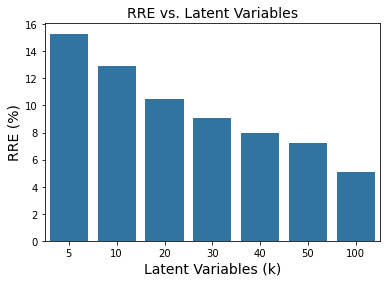

In [15]:
ax = sns.barplot(x = list(nvarDict.keys()), y = [i*100 for i in list(nvarDict.values())], color = "tab:blue")
ax.set_xlabel('Latent Variables (k)', fontsize=14)
ax.set_ylabel('RRE (%)', fontsize=14)
ax.set_title("RRE vs. Latent Variables", fontsize=14)
plt.show()

Using 100 latent variables, we still achieve compression with a base error of ~ 5% without any noise in the images. However with a data set of only 400 people, using 100 latent variables means that the basis will likely overfit to the data and would not generalise well to images of new faces. Thus I am going to use 20. 

## 4.3 $L_2$ norm NMF without noise

Now let's examine how NMF learns a parts-based representation of non-negative data. We will run the $L_2$-norm NMF on the olivetti faces data set, and then reconstruct the images (data matrix $R$) using the learned matrices $P$ and $Q$. 

In [16]:
# Initialise P and Q matrices with 20 latent variables
P, Q = initialiseDictCoeff(images, 20)
R = images
print(f"R is an {R.shape[0]} x {R.shape[1]} matrix")
print(f"P is an {P.shape[0]} x {P.shape[1]} matrix")
print(f"Q is an {Q.shape[0]} x {Q.shape[1]} matrix")

R is an 400 x 1024 matrix
P is an 400 x 20 matrix
Q is an 1024 x 20 matrix


So we can see that a matrix with the same dimensions as $R$ can be reconstructed via $PQ^T$. To understand why this is the case, see this page: https://en.wikipedia.org/wiki/Matrix_multiplication

Now let's run the l2norm algorithm to learn P and Q:

In [17]:
P, Q = l2Norm(R, P, Q, steps=1000)

We can reconstruct the original data $R$, calling the reconstructed version $\hat{R}$:

In [18]:
Rhat = P@Q.T

Now let's examine some of the reconstructed images alongside the original:

In [19]:
def plot_reconstructions(P, Q, R, imageShape, num_examples = 5):
    # reconstruct from learned P and Q
    Rhat = P @ Q.T
    # reshape to square images
    Rhat = Rhat.reshape(Rhat.shape[0], imageShape[0], imageShape[1])
    R = R.reshape(R.shape[0], imageShape[0], imageShape[1])
    # create the figure
    fig, axis = plt.subplots(num_examples, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(num_examples):
        randInt = np.random.randint(Rhat.shape[0]) 
        # plot original on left
        ax = axis[i, 0]
        ax.imshow(R[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        # plot reconstruction on right
        ax = axis[i, 1]
        ax.imshow(Rhat[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        # column titles
        if i == 0:
            axis[i, 0].set_title('Original')
            axis[i, 1].set_title('Reconstruction')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


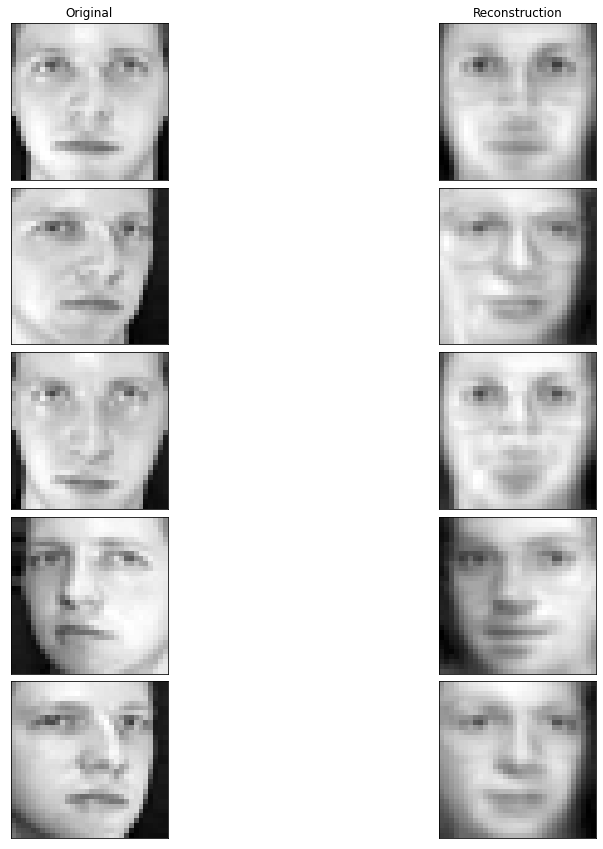

In [20]:
plot_reconstructions(P, Q, R, imageShape)

We can see that the reconstructions are imperfect, particularly struggling to capture the noise and eyes of individuals, but the overall facial structure is well captured.

The matrix $Q$ contains the learned bases, we can examine these to understand how an image was deconstructed:

In [21]:
#show the learned basis
def plot_learned_basis(Q):
    # reshape Q for plotting
    Q = Q.reshape(32, 32, 20)
    fig, axis = plt.subplots(4,5) # adjust if you select a different number of latent vars
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle("Learned basis images from NMF", size=16)
    idx = 0
    for i in range(4): # adjust if you select a different number of latent vars
        for j in range(5): # adjust if you select a different number of latent vars
            ax = axis[i, j]
            ax.imshow(Q[:, :, idx], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            idx += 1
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

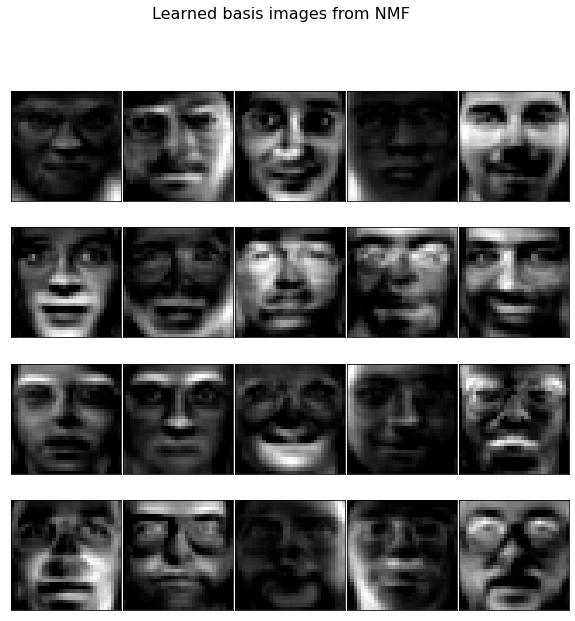

In [22]:
plot_learned_basis(Q)

We can see that these basis are mostly small positive value images (mostly black), meaning they combine in an additive manner when multiplied with $P$ to reconstruct $R$. The highlighted parts (lighter areas) for each basis image indicate the dominant part of the face contained in that basis image. 

For example we see images with lighter areas for the nose, eyebrows, upper lip, different sides of the face, under the chin etc. All these components of a face combine additively to form a face.

# 5. Noisy Data

Now that we understand the basic concept of NMF, we can examine the performance of some different algorithms in a more realistic setting: with noisy images. 

Here are 3 algorithms to introduce different types of noise to the images:

## 5.1 Random White Pixels

Here, a specified proportion of random pixels are set to white. The proportion of white pixels (value 255) can be changed to trial different noise levels. 

In [23]:
#The noise algorithm required by the assignment description
def addRandomWhitePixels(data, probWhite=0.2):
    data = np.copy(data)
    rand = np.random.random(data.shape)
    data[rand < probWhite] = np.max(data)
    return data

Here is an example with the noise level (proportion of white pixels) set to be 10%:

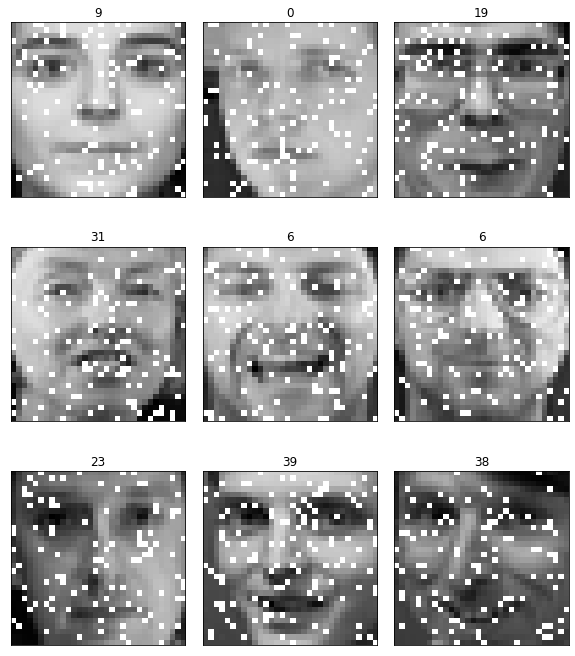

In [24]:
#Load data and add random white pixels
noisyImages = addRandomWhitePixels(images, probWhite=0.1)
plotImages(noisyImages, labels, imageShape = (400, 32,32))

## 5.2 Laplacian Noise

To test the algorithms robustness to a second noise type, we created a function to add noise drawn from a laplacian distribution. 

In [25]:
def addLaplacePixels(data, delta = 10):
    """
    Adds laplacian noise to the images.
    """
    data = np.copy(data)
    rand = np.random.laplace(scale = delta, size = data.shape)
    data = data + rand
    return data

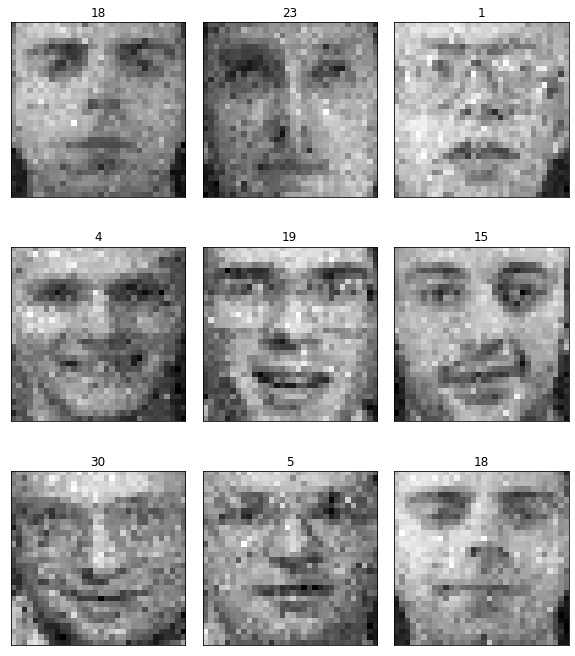

In [26]:
# Load data and add white pixels based on laplacian distribution
noisyImagesLaplace = addLaplacePixels(images, delta = 10)
plotImages(noisyImagesLaplace, labels, imageShape=(400,32,32))

## 5.3 Random White Boxes

This simple algorithm adds a random white box to the images. We specify the minimum width and height of the box, and the code bellow will add a white box at a random location, covering a specified proportion of the image.

In [27]:
def addRandomWhiteBoxes(images, proportion=0.2):
    images = np.copy(images)
    width = images.shape[2]
    height = images.shape[1]
    imageArea = width * height
    minWidth = int(proportion * imageArea / height) + 1
    for image in images:
        boxWidth = np.random.choice(np.arange(minWidth, width))
        boxHeight = int(proportion * imageArea / boxWidth)
        randX = np.random.choice(np.arange(width - boxWidth))
        randY = np.random.choice(np.arange(height - boxHeight + 1))
        image[randY:randY+boxHeight, randX:randX+boxWidth] = 255
    return images

Here we cover 10% of the image with a box. Compare this to the random white pixels algorithm above which also corrupts 10% of the image with white pixels.

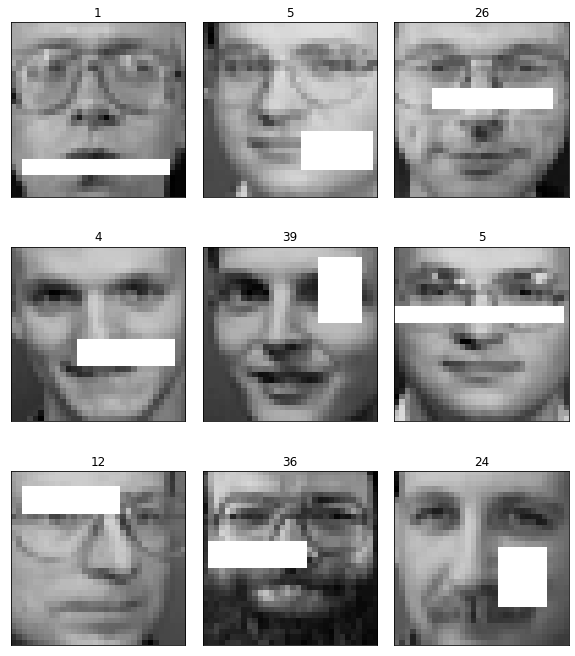

In [28]:
#Load data, add random boxes and plot a random selection of images
ims = images.reshape(400,32,32)
boxyImages = addRandomWhiteBoxes(ims, 0.1)
plotImages(boxyImages, labels, imageShape=(400,32,32))

# 6. NMF Algorithms

Here is an additional NMF algorithm that aims to be robust to noise, we will compare it to the standard $L_2$ norm NMF algorithm. In future, additional algorithms will be added to this tutorial.

## 6.1 $L_{2,1}$ norm NMF

Here we implement an NMF algorithm using an $L_{2,1}$ loss function as described in https://dl.acm.org/doi/abs/10.1145/2063576.2063676

The error function is formulated as:
$$
||R-PQ^T||_{2,1}=\sum^n_{i=1}\sqrt{\sum^p_{j=1}(R-PQ^T)^2_{ji}}=\sum^n_{i=1}||r_i-p_iQ^T||
$$

The error for each data point is $||r_i-p_iQ^T||$, which is not squared and thus reduces the influence of larger errors in comparison to the $L_2$ loss function.

The optimisation problem can be summarised as
$$
\min_{Q,P}||R-PQ^T||_{2,1} s.t. Q\ge0, P\ge 0
$$

The update rules as given by Kong et al. are 
$$
Q' = Q\frac{(R^TDP)}{(QP^TDP)}
$$
$$
P' = (P.T\frac{(Q^TRD)}{(Q^TQP.TD)}).T
$$
where $D$ is a diagonal matrix with the diagonal elements given by
$$
D_{ii} = \frac{1}{\sqrt{\sum^p_{j=1}(R-PQ^T)^2}}=\frac{1}{||r_i-p_iQ^T||}
$$

In [29]:
def l21Norm(R, P, Q, steps=300):
        
    for step in range(steps):
        d = np.square(R - P @ Q.T)
        D = np.diag(np.reciprocal(np.sqrt(np.sum(d.T, axis=0))))
        
        Q = Q * (R.T @ D @ P) / (Q @ P.T @ D @ P)
        P = (P.T * (Q.T @ R.T @ D) / (Q.T @ Q @ P.T @ D)).T
        
        #Force algorithm to avoid negatives and zeros
        Q[Q<=0] = 1e-50
        P[P<=0] = 1e-50
        
    return P, Q

## 6.2 $L_1$ norm NMF

If we assume that the data $R$ has been corrupted by additive noise, then we have that $\hat{R} = R + E$ where $\hat{R}$ is the clean data matrix, and $E$ is an $n \times m $ matrix representing the corruption. In https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICIP-2014/Papers/1569911469.pdf, they show how NMF using an objective function based on the $L_1$ norm can handle this type of noise. 

Since all noise algorithms are a type of additive noise, the $L_1$ norm based NMF should perform better than the $L_2$ norm. 

Now we approximate the clean data $\hat{R}$ by learning $P$, $Q$ from the noisy data $R$, so $\hat{R} \approx PQ.T + E$. In this model, the authors further assume that the noise $E$ is sparsely added, so we should expect this algorithm to show robustness at low proportions of noise, but not higher proportions. The sparsity constraint leads to the objective function being formulised as 
$$
loss = ||R-PQ.T-E||^2_F + \lambda\sum_j[||E_{.j}||_0]^2
$$
where $||\cdot||_0$ is the $L_0$ norm. However the $L_0$ norm is difficult to optimise, and thus the $L_1$ norm is used in its place, leading to the objective function being defined as
$$
loss = ||R-PQ.T-E||^2_F + \lambda\sum_j[||E_{.j}||_1]^2
$$

In the paper, they provide multiplicative update rules and prove thier convergence, the rules are:

To update $Q$:
$$
Q = Q\times \frac{\hat{R}^TP}{QP^TP}.
$$

To update $P$, first we let $\tilde{P}=\begin{bmatrix}P & \begin{bmatrix}E^p & E^n\end{bmatrix}\end{bmatrix}$, where $E^p=\frac{|E|+E}{2}, E^n=\frac{|E|-E}{2}$. Then $P$, $E^p$, and $E^n$ can be updated by the following rule:

$$
\tilde{P}_{ij} = max(0, \tilde{P}_{ij} - \frac{\tilde{P}_{ij} \times (\tilde{P}\tilde{Q}^T\tilde{Q})}{\tilde{P}S} + \frac{\tilde{P}_{ij}\times (\tilde{R}\tilde{Q})}{\tilde{P}S})
$$
where $S_{ij} = |(Q^TQ)_{ij}|$, $\tilde{Q} = \begin{bmatrix} Q, I, -I \\ 0_{1\times k}\sqrt{\lambda}e_{1\times m}\sqrt{\lambda}e_{1\times m} \end{bmatrix}$, $\tilde{R} = \begin{bmatrix} X & 0_{n\times 1} \end{bmatrix}$.

Note for these equations, the paper uses an alternative NMF notation with $X = UV$ where $X$ is an $m \times n$ matrix, $U$ is an $m \times k$ matrix, and $V$ is a $k \times n$ matrix. I have translated the notation to be consistent with that used throughout this notebook, where $n$ still represents the number of observations, $m$ the image dimension, and $k$ the latent variables.

In [30]:
def l1Norm(R, P, Q, lamda, steps = 1000):
    """
    Runs an L1 norm NMF optimisation.
    """
    # Constant values
    n = R.shape[0]
    m = R.shape[1]
    k = P.shape[1]
    e1 = np.zeros(m)
    e1[0] = 1.
    RTilde = np.c_[R, np.zeros(n)]
    
    # initialise Ep, En, PTilde matrices
    Ep = np.uint8(np.zeros((n, m)))
    En = np.uint8(np.zeros((n, m)))
    PTilde = np.c_[P, Ep, En]
    
    for i in range(steps):
        # Update estimate for Rhat (R-E)
        Rhat = R - Ep + En
        Rhat[Rhat<0] = 0 # based on constraint given in paper
        
        # Update Q
        Q = Q * ((Rhat.T @ P) / (Q@P.T@P))
        
        # Update P
        qtTop = np.c_[Q, np.identity(m), -np.identity(m)]
        qtBot = np.concatenate((np.zeros(k), np.sqrt(lamda)*e1, np.sqrt(lamda)*e1), axis=0)
        QTilde = np.row_stack((qtTop, qtBot))
        
        S = np.absolute(QTilde.T@QTilde)
        
        PTilde = PTilde - (PTilde * ((PTilde @ QTilde.T @ QTilde) / (PTilde@S))) + (PTilde * ((RTilde @ QTilde)/(PTilde@S)))
        PTilde[PTilde < 0] = 0 # implements the max operation
        
        # Extract updated P, Ep, En
        P = PTilde[:, :k]
        Ep = PTilde[:, k:k+m]
        En = PTilde[:, k+m:]
        
        # Force matrices to be positive
        Q[Q<=0] = 1e-50
        P[P<=0] = 1e-50
        Ep[Ep<=0] = 1e-50
        En[En<=0] = 1e-50
        
    return P, Q

Here is an example of how the $L_1$ norm based NMF can remove additive noise from images:

In [31]:
# Load datasets
images, labels = load_images(scaleDownFactor=2)
imageShape = (images.shape[1], images.shape[2]) # having the original image shape will help later
images = preprocess_images(images)

# Create 5-folds of 90% each
image_Folds, label_Folds, P_Folds, Q_Folds = createFolds(images, labels, portion = 0.9, numFolds = 5, nLatentVariables = 20)
R = addRandomWhitePixels(image_Folds[0], probWhite=0.1)
P = P_Folds[0]
Q = Q_Folds[0]

In [33]:
P, Q = l1Norm(R, P, Q, 0.04, steps=300)

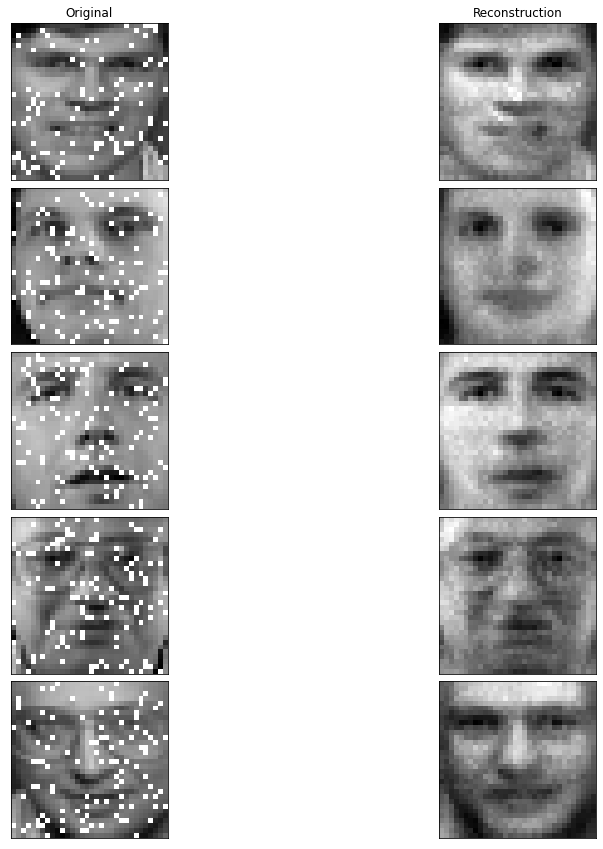

In [34]:
plot_reconstructions(P, Q, R, imageShape)

# 7. Comparison of NMF Algorithms

## 7.1 Functions to run a GridSearchCV NMF

These are custom functions that will run 5-fold CV with a given noise algorithm, dataset, list of NMF functions, and dictionary of parameter values for each function.

In [35]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def do_Fold_NMF(foldData, labels, noise_amounts, NMF_function, noiseFunction, paramValue = None, imageShape = None):
    foldRRE = dict() 
    foldAcc = dict()
    foldNMI = dict()
    for n in noise_amounts:
        foldRRE[n] = list()
        foldAcc[n] = list()
        foldNMI[n] = list()
        for i, f in enumerate(foldData):
            R_hat, P, Q = f[0], f[1], f[2]
            # Add some noise
            if imageShape is not None:
                R_hat = R_hat.reshape(R_hat.shape[0], imageShape[0], imageShape[1])
                R = noiseFunction(R_hat, n)
                R = R.reshape(R.shape[0], R.shape[1]*R.shape[2])
                R_hat = R_hat.reshape(R_hat.shape[0], imageShape[0]*imageShape[1])
            else:
                R = noiseFunction(R_hat, n)
            # Run NMF
            if paramValue is not None:
                P, Q = NMF_function(R, P, Q, paramValue, steps=200)
            else:
                P, Q = NMF_function(R, P, Q, steps=200)
            # Calculate RRE
            foldRRE[n].append(RRE(R_hat, P, Q))
            # Calculate Accuracy and NMI
            preds = assign_cluster_label(P, labels[i])
            foldAcc[n].append(accuracy_score(labels[i], preds))
            foldNMI[n].append(normalized_mutual_info_score(labels[i], preds))

    return {'noise': {'RRE': foldRRE, 'Acc': foldAcc, 'NMI': foldNMI}}
    
def RUN_NMF_GRID(foldData, labels, noise_amounts, NMF_Functions, paramDict, noiseFunction, imageShape = None):
    """
    Runs 5 fold CV for different levels of noise, and specified parameters. 
    """
    results = dict()

    for model in NMF_Functions:
        startTime = time.time()
        if model in paramDict:
            paramResults = dict()
            for param in paramDict[model]:
                paramValueResults = dict()
                for paramValue in paramDict[model][param]:
                    foldResults = do_Fold_NMF(foldData, labels, noise_amounts, NMF_Functions[model], noiseFunction, 
                                          paramValue, imageShape)        
                    paramValueResults[paramValue] = foldResults
                paramResults[param] = paramValueResults
            results[model] = {'Parameter': paramResults}
        else:
            foldResults = do_Fold_NMF(foldData, labels, noise_amounts, NMF_Functions[model], noiseFunction, 
                                      imageShape = imageShape)
            results[model] = foldResults
        endTime = time.time()
        print(f"{model} runtime (minutes):", (endTime - startTime)/60)
            
    return results
                        

# 7.2 Loading Data

Let's load the data and create some folds:

In [36]:
# Load datasets
images, labels = load_images(scaleDownFactor=2)
imageShape = (images.shape[1], images.shape[2]) # having the original image shape will help later
images = preprocess_images(images)

# Create 5-folds of 90% each
image_Folds, label_Folds, P_Folds, Q_Folds = createFolds(images, labels, portion = 0.9, numFolds = 5, nLatentVariables = 100)

Now we can examine the shape of our 90% fold, we expect 360 32 x 32 images, meaning $R$ should have shape $360 x 1024$:

In [37]:
print("R Shape:", image_Folds[0].shape)
print("Labels Shape:", label_Folds[0].shape)
print("P Shape:", P_Folds[0].shape)
print("Q Shape:", Q_Folds[0].shape)

R Shape: (360, 1024)
Labels Shape: (360,)
P Shape: (360, 100)
Q Shape: (1024, 100)


## 7.3 NMF with Random White Pixels

NMF Functions:
* l2 norm NMF
* l21 norm NMF
* l1 norm NMF with lamda parameter values of 0.01, 0.05, 0.1

Noise Type:
* Percentage of pixels are turned white (as specified in the assignment spec)

Noise Amounts:
* 0%, 5%, 10%, 20%, 30%, 40%, 50%, 60%, 70%

In [38]:
# Specify noise amounts
white_noise_amounts = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# Specify NMF Functions
functions = {'l2-norm': l2Norm, 'l21-norm': l21Norm, 'l1-norm': l1Norm}
# Specify Parameters for each function
paramDict = {'l1-norm': {"lamda": [0.01, 0.05, 0.1]}} 
# Prepare fold data
Fold_Data = [(r, p, q) for r, p, q in zip(image_Folds, P_Folds, Q_Folds)]

# Run NMF
print("======== Starting ========")
whiteNoise_results = RUN_NMF_GRID(Fold_Data, label_Folds, white_noise_amounts, 
                                      functions, paramDict, addRandomWhitePixels)
print("======== Finished ========")

======== Starting ========
l2-norm runtime (minutes): 0.48759775161743163
l21-norm runtime (minutes): 0.9771232366561889
l1-norm runtime (minutes): 45.524068097273506
======== Finished ========


## 7.4 NMF with Random White Boxes

NMF Functions:
* l2 norm
* l21 norm
* l1 norm NMF with lamda parameter values of 0.01, 0.05, 0.1

Noise Type:
* Random white boxes placed on the images, of varying proportions.

Noise Amounts:
* 0%, 5%, 10%, 20%, 30%, 40%, 50%, 60%, 70%

In [44]:
# Specify noise amounts
box_noise_values = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] 
# Specify NMF Functions
functions = {'l2-norm': l2Norm, 'l21-norm': l21Norm, 'l1-norm': l1Norm}
# Specify Parameters for each function
paramDict = {'l1-norm': {"lamda": [0.01, 0.05, 0.1]}} 
# Prepare fold data
Fold_Data = [(r, p, q) for r, p, q in zip(image_Folds, P_Folds, Q_Folds)]

# Run NMF
# For this noise function we need to pass the image shape in 2D. 
print("======== Starting ========")
boxNoise_results = RUN_NMF_GRID(Fold_Data, label_Folds, box_noise_values, 
                                      functions, paramDict, addRandomWhiteBoxes, imageShape) 
print("======== Finished ========")

======== Starting ========
l2-norm runtime (minutes): 0.5429344296455383
l21-norm runtime (minutes): 1.0312082211176554
l1-norm runtime (minutes): 43.62445199886958
======== Finished ========


## 7.5 NMF with Laplacian Noise

NMF Functions:
* l2 norm
* l21 norm
* l1 norm NMF with lamda parameter values of 0.01, 0.05, 0.1

Noise Type:
* Laplacian noise added, of varying delta values (scale parameter in Laplacian distribution)

Noise Amounts:
* 0, 5, 10, 40, 80, 120, 160, 200, 240, 280

In [45]:
# Specify noise amounts
lap_noise_values = [0, 5, 10, 40, 80, 120, 160, 200, 240, 280] 
# Specify NMF Functions
functions = {'l2-norm': l2Norm, 'l21-norm': l21Norm, 'l1-norm': l1Norm}
# Specify Parameters for each function
paramDict = {'l1-norm': {"lamda": [0.01, 0.05, 0.1]}} 
# Prepare fold data
Fold_Data = [(r, p, q) for r, p, q in zip(image_Folds, P_Folds, Q_Folds)]
# Run NMF
print("======== Starting ========")
lapNoise_results = RUN_NMF_GRID(Fold_Data, label_Folds, lap_noise_values, 
                                      functions, paramDict, addLaplacePixels) 
print("======== Finished ========")

======== Starting ========
l2-norm runtime (minutes): 0.48273571729660036
l21-norm runtime (minutes): 0.9666881163914999
l1-norm runtime (minutes): 48.17735344568889
======== Finished ========


# 8. Printing and Saving Results

Here I define functions to print the full results tables from the cross-validation data, and also export formatted tables. 

In [46]:
import pandas as pd # pandas only used for printing results table

def make_results_table(resultsDict):
    """
    Prints a dataframe/table of results
    """
    index = 0
    resultsDf = pd.DataFrame()
    for model in resultsDict:
        if "noise" in list(resultsDict[model].keys()):
            # make table for noise for this model
            for noise_amount in resultsDict[model]['noise']['RRE']:
                RREfiveFoldCV_results = resultsDict[model]['noise']['RRE'][noise_amount]
                AccfiveFoldCV_results = resultsDict[model]['noise']['Acc'][noise_amount]
                NMIfiveFoldCV_results = resultsDict[model]['noise']['NMI'][noise_amount]
                RREmean = np.average(RREfiveFoldCV_results)
                RREsd = np.std(RREfiveFoldCV_results)
                Accmean = np.average(AccfiveFoldCV_results)
                Accsd = np.std(AccfiveFoldCV_results)
                NMImean = np.average(NMIfiveFoldCV_results)
                NMIsd = np.std(NMIfiveFoldCV_results)
                
                row = pd.DataFrame({'model': model, 'parameter': None, 'parameterValue': None,
                                    'noise': [noise_amount], 'RRE (mean)': RREmean, 'RRE (sd)': RREsd, 
                                   "Acc (mean)": Accmean, "Acc (sd)": Accsd, "NMI (mean)": NMImean,
                                   "NMI (sd)": NMIsd}, index = [index])
                resultsDf = resultsDf.append(row)
                index += 1
        else:
            # GridSearchOverParameters was run
            for parameter in resultsDict[model]['Parameter']:
                for paramValue in resultsDict[model]['Parameter'][parameter]:
                    for noise_amount in resultsDict[model]['Parameter'][parameter][paramValue]['noise']['RRE']:
                        RREfiveFoldCV_results = resultsDict[model]['Parameter'][parameter][paramValue]['noise']['RRE'][noise_amount]
                        AccfiveFoldCV_results = resultsDict[model]['Parameter'][parameter][paramValue]['noise']['Acc'][noise_amount]
                        NMIfiveFoldCV_results = resultsDict[model]['Parameter'][parameter][paramValue]['noise']['NMI'][noise_amount]
                        RREmean = np.average(RREfiveFoldCV_results)
                        RREsd = np.std(RREfiveFoldCV_results)
                        Accmean = np.average(AccfiveFoldCV_results)
                        Accsd = np.std(AccfiveFoldCV_results)
                        NMImean = np.average(NMIfiveFoldCV_results)
                        NMIsd = np.std(NMIfiveFoldCV_results)
                        row = pd.DataFrame({'model': model, 'parameter': parameter, 'parameterValue': paramValue,
                                            'noise': [noise_amount], 'RRE (mean)': RREmean, 'RRE (sd)': RREsd,
                                            "Acc (mean)": Accmean, "Acc (sd)": Accsd, "NMI (mean)": NMImean,
                                            "NMI (sd)": NMIsd}, index = [index])
                        resultsDf = resultsDf.append(row)
                        index += 1
    return resultsDf

In [47]:
whiteNoise_resultsDf = make_results_table(whiteNoise_results)
boxNoise_resultsDf = make_results_table(boxNoise_results)
lapNoise_resultsDf = make_results_table(lapNoise_results)

#### Example results

In [48]:
whiteNoise_resultsDf

,model,parameter,parameterValue,noise,RRE (mean),RRE (sd),Acc (mean),Acc (sd),NMI (mean),NMI (sd)
0,l2-norm,None,NaN,0.00,0.078311,0.000800,0.705556,0.020261,0.815509,0.006284
1,l2-norm,None,NaN,0.05,0.123470,0.001688,0.682778,0.035893,0.797558,0.019318
2,l2-norm,None,NaN,0.10,0.172578,0.002361,0.553333,0.045250,0.695596,0.028356
3,l2-norm,None,NaN,0.20,0.255861,0.003413,0.378333,0.030651,0.531451,0.035606
4,l2-norm,None,NaN,0.30,0.330557,0.004759,0.266667,0.012790,0.422519,0.019539
5,l2-norm,None,NaN,0.40,0.401445,0.005803,0.223333,0.025975,0.355822,0.047611
6,l2-norm,None,NaN,0.50,0.470823,0.006237,0.197778,0.008854,0.322781,0.018625
7,l2-norm,None,NaN,0.60,0.537018,0.007655,0.186111,0.006334,0.297260,0.018386
8,l2-norm,None,NaN,0.70,0.603941,0.008322,0.177778,0.006334,0.271343,0.026680
9,l21-norm,None,NaN,0.00,0.079959,0.000656,0.721111,0.034138,0.823201,0.019395


#### Saving the results

In [49]:
whiteNoise_resultsDf.to_csv("whiteNoise_results.csv", index = False)

In [50]:
boxNoise_resultsDf.to_csv("boxNoise_results.csv", index = False)

In [51]:
lapNoise_resultsDf.to_csv("lapNoise_results.csv", index = False)

## 8.1 Inspecting Results

If you wanted to skip directly to the results, you can load the csv files provided here and follow the next steps:

In [52]:
import pandas as pd
whiteNoise_resultsDf = pd.read_csv("whiteNoise_results.csv")
boxNoise_resultsDf = pd.read_csv("boxNoise_results.csv")
lapNoise_resultsDf = pd.read_csv("lapNoise_results.csv")

Run the below cell to inspect the results of all four algorithms after adding white noise of varying levels to the Yale dataset. 

### 8.1.1 Creating Data Tables (suitable for report)

In [59]:
def format_results_df(resultsDF, noiselabel = 'p'):
    """
    Create a results table ready to be added to the final report.
    """
    RRE = pd.DataFrame()
    Acc = pd.DataFrame()
    NMI = pd.DataFrame()
    
    # Add noise column
    noiseVals = sorted(list(set(resultsDF.noise)))
    RRE[noiselabel] = noiseVals
    Acc[noiselabel] = noiseVals
    NMI[noiselabel] = noiseVals
    for m in list(set(resultsDF.model)):
        if m == 'l1-norm':
            df = resultsDF.groupby('parameterValue').mean()
            bestLamda = df.loc[df['RRE (mean)'].idxmin()].name
        for metric in ['RRE', 'Acc', 'NMI']:
            if m != 'l1-norm':
                mean = list(resultsDF[resultsDF.model == m][f'{metric} (mean)'])
                mean = [str(round(m*100, 2)) for m in mean]
                sd = list(resultsDF[resultsDF.model == m][f'{metric} (sd)'])
                sd = [str(round(s*100, 2)) for s in sd]
                res = [m+'('+s+')' for m,s in zip(mean, sd)]
            else:
                mean = list(resultsDF.loc[(resultsDF.model == m) & (resultsDF.parameterValue == bestLamda)][f'{metric} (mean)'])
                mean = [str(round(m*100, 2)) for m in mean]
                sd = list(resultsDF.loc[(resultsDF.model == m) & (resultsDF.parameterValue == bestLamda)][f'{metric} (sd)'])
                sd = [str(round(s*100, 2)) for s in sd]
                res = [m+'('+s+')' for m,s in zip(mean, sd)]
                
            if metric == 'RRE':
                RRE[m] = res
            elif metric == 'Acc':
                Acc[m] = res
            else:
                NMI[m] = res
                
    return RRE, Acc, NMI

Saving formatted data tables:

In [60]:
RRE, Acc, NMI = format_results_df(whiteNoise_resultsDf)
#RRE.to_csv("whiteNoise_RRE.csv")
#Acc.to_csv("whiteNoise_Acc.csv")
#NMI.to_csv("whiteNoise_NMI.csv")
RRE, Acc, NMI = format_results_df(boxNoise_resultsDf)
#RRE.to_csv("boxNoise_RRE.csv")
#Acc.to_csv("boxNoise_Acc.csv")
#NMI.to_csv("boxNoise_NMI.csv")
RRE, Acc, NMI = format_results_df(lapNoise_resultsDf, noiselabel=r"$\lambda$")
#RRE.to_csv("lapNoise_RRE.csv")
#Acc.to_csv("lapNoise_Acc.csv")
#NMI.to_csv("lapNoise_NMI.csv")

For example, here are the mean and standard deviation across the 5 folds for relative reconstruction error when laplacian noise is added, comparing the different loss functions:

In [61]:
RRE

,$\lambda$,l1-norm,l2-norm,l21-norm
0,0,7.83(0.08),7.83(0.08),8.0(0.07)
1,5,8.06(0.08),8.07(0.09),8.19(0.07)
2,10,8.8(0.08),8.8(0.08),8.88(0.07)
3,40,19.88(0.14),20.88(0.12),20.89(0.18)
4,80,36.48(0.29),38.52(0.28),38.78(0.34)
5,120,57.09(0.45),55.72(0.2),56.19(0.39)
6,160,79.46(0.75),73.06(0.62),73.21(0.74)
7,200,98.37(0.81),89.95(0.6),89.47(0.66)
8,240,114.52(1.31),106.11(0.55),105.34(0.77)
9,280,132.69(1.24),122.23(0.77),120.87(1.1)
